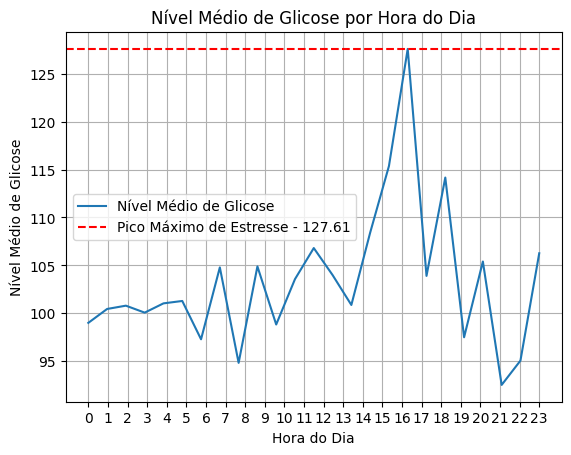

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import mysql.connector

# Função para simular a coleta de dados de glicose ao longo de um período de tempo
def simulate_glucose(duration_minutes, sample_interval_seconds, stress_times):
    # Inicialize uma lista para armazenar os níveis de glicose
    glucose_levels = []
    
    # Defina o tempo total de simulação em segundos
    total_duration_seconds = duration_minutes * 60
    
    # Defina o tempo inicial da simulação
    start_time = time.time()
    
    # Simule a coleta de dados de glicose até atingir a duração total
    while time.time() - start_time < total_duration_seconds:
        # Calcule o tempo decorrido desde o início da simulação
        elapsed_time = time.time() - start_time
        
        # Calcule o número de minutos decorridos desde o início da simulação
        elapsed_minutes = elapsed_time / 60
        
        # Calcule o número da hora atual ajustado para representar 24 horas
        current_hour = (elapsed_minutes / duration_minutes) * 24
        
        # Calcule o nível de glicose para esta hora
        if current_hour <= 6:  # Estabilizar as primeiras 6 horas
            glucose_level = 100 + np.random.normal(0, 5)
        else:
            glucose_level = 100 + np.random.normal(0, 20)
        
        # Verifique se há um pico de estresse neste momento
        for stress_time in stress_times:
            if current_hour >= stress_time and current_hour < stress_time + 1:
                glucose_level += np.random.uniform(20, 40)
        
        # Certifique-se de que os valores de glicose não sejam negativos
        glucose_level = max(glucose_level, 0)
        
        # Adicione o nível de glicose à lista
        glucose_levels.append(glucose_level)
        
        # Aguarde o intervalo de amostragem antes da próxima coleta de dados
        time.sleep(sample_interval_seconds)
    
    return glucose_levels

# Função para calcular a média da glicose por hora do dia
def calculate_glucose_per_hour(glucose_levels):
    # Divida os dados de glicose em intervalos representando cada hora do dia
    glucose_per_hour = [np.mean(glucose_levels[i:i+12]) for i in range(0, len(glucose_levels), 12)]
    return glucose_per_hour

# Função para inserir os dados no banco de dados MySQL
def insert_data_to_mysql(glucose_levels):
    # Estabelecer conexão com o banco de dados MySQL
    conn = mysql.connector.connect(
        host="localhost",
        user="nogueira",
        password="1234",
        database="glicose"
    )
    cursor = conn.cursor()
    
    # Criar a tabela se não existir
    cursor.execute('''CREATE TABLE IF NOT EXISTS glucose_data (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        glucose_level FLOAT
                      )''')
    
    # Inserir os dados de glicose na tabela
    for glucose_level in glucose_levels:
        cursor.execute("INSERT INTO glucose_data (glucose_level) VALUES (%s)", (glucose_level,))
    
    # Commit as mudanças e feche a conexão
    conn.commit()
    conn.close()

# Horários de estresse com picos de glicose (em horas)
stress_times = [14, 16, 18]

# Simulação da coleta de dados de glicose ao longo de um período de tempo especificado
glucose_levels = simulate_glucose(5, 1, stress_times)  # Simular 5 minutos com intervalo de amostragem de 1 segundo

# Inserir os dados no banco de dados MySQL
insert_data_to_mysql(glucose_levels)

# Calculando a média da glicose por hora do dia
glucose_per_hour = calculate_glucose_per_hour(glucose_levels)

# Encontrando o máximo entre os valores de glicose nos horários de estresse
max_pico_glicose = max(glucose_per_hour)

# Plotando o gráfico da glicose por hora
plt.plot(range(len(glucose_per_hour)), glucose_per_hour, label='Nível Médio de Glicose')
plt.xlabel('Hora do Dia')
plt.ylabel('Nível Médio de Glicose')
plt.title('Nível Médio de Glicose por Hora do Dia')
plt.xticks(np.linspace(0, len(glucose_per_hour) - 1, num=24), range(24))

# Adicionando linha pontilhada horizontal no pico máximo de glicose nos horários de estresse
plt.axhline(y=max_pico_glicose, color='r', linestyle='--', label=f'Pico Máximo de Estresse - {max_pico_glicose:.2f}')

plt.grid(True)
plt.legend()
plt.show()


In [4]:
import numpy as np
import time
import json
from datetime import datetime
from azure.iot.device import IoTHubDeviceClient, Message

# Função para obter a data atual no formato ISO 8601
def get_current_iso_date():
    return datetime.utcnow().isoformat()

# Função para simular a coleta de dados de glicose com bateria
def simulate_glucose_with_battery(sample_interval_seconds, stress_times, device_id):
    # Inicialize listas para armazenar os dados
    data_list = []
    
    # Coleta de dados contínua até ser interrompida
    while True:
        # Calcule o nível de glicose
        if np.random.rand() < 0.5:
            glucose_level = 100 + np.random.normal(0, 5)
        else:
            glucose_level = 100 + np.random.normal(0, 20)
        
        # Calcule a carga da bateria
        battery_level = 100 - 0.1 * (len(data_list) * sample_interval_seconds / 120)  # A bateria diminui 0.1% a cada 2 minutos
        
        # Crie um dicionário com os dados
        data = {
            "device_id": device_id,
            "date": get_current_iso_date(),
            "glucose_level": glucose_level,
            "battery_level": battery_level
        }
        
        # Adicione os dados à lista
        data_list.append(data)
        
        # Print dos dados coletados
        print("Dados coletados:", data)
        
        # Aguarde o intervalo de amostragem antes da próxima coleta de dados
        time.sleep(sample_interval_seconds)
    
    return data_list

# Função para enviar os dados para o IoT Hub da Azure em formato JSON
def send_data_to_azure_iot_hub(data_list):
    # Conecte-se ao dispositivo do IoT Hub da Azure
    conn_str = ""
    device_client = IoTHubDeviceClient.create_from_connection_string(conn_str)
    
    # Conecte-se ao IoT Hub
    device_client.connect()
    
    try:
        # Coletar dados enquanto houver
        while True:
            if data_list:
                data = data_list.pop(0)
                message = Message(json.dumps(data))
                device_client.send_message(message)
                # Print dos dados enviados
                print("Dados enviados:", data)
            else:
                time.sleep(1)  # Aguarde um segundo se não houver dados
    finally:
        # Desconecte-se do IoT Hub quando terminar
        device_client.disconnect()

# Horários de estresse com picos de glicose (em horas)
stress_times = [14, 16, 18]

# ID do dispositivo IoT
device_id = "eagleNogueira"

# Coletar dados de glicose com bateria a cada 2 minutos
data_list = simulate_glucose_with_battery(10, stress_times, device_id)

# Enviar os dados para o IoT Hub da Azure em formato JSON

send_data_to_azure_iot_hub(data_list)


Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:09:17.457083', 'glucose_level': 102.98453087892554, 'battery_level': 100.0}
Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:09:27.462483', 'glucose_level': 93.38477777673704, 'battery_level': 99.99166666666666}
Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:09:37.466426', 'glucose_level': 81.01429109539771, 'battery_level': 99.98333333333333}


KeyboardInterrupt: 

In [6]:
import numpy as np
import time
import json
from datetime import datetime
from azure.iot.device import IoTHubDeviceClient, Message

# Função para obter a data atual no formato ISO 8601
def get_current_iso_date():
    return datetime.utcnow().isoformat()

# Função para simular a coleta de dados de glicose com bateria
def simulate_glucose_with_battery(sample_interval_seconds, stress_times, device_id):
    # Coleta de dados contínua até ser interrompida
    while True:
        # Calcule o nível de glicose
        if np.random.rand() < 0.5:
            glucose_level = 100 + np.random.normal(0, 5)
        else:
            glucose_level = 100 + np.random.normal(0, 20)
        
        # Calcule a carga da bateria
        battery_level = 100 - 0.1 * sample_interval_seconds / 120  # A bateria diminui 0.1% a cada 2 minutos
        
        # Crie um dicionário com os dados
        data = {
            "device_id": device_id,
            "date": get_current_iso_date(),
            "glucose_level": glucose_level,
            "battery_level": battery_level
        }
        
        # Print dos dados coletados
        print("Dados coletados:", data)
        
        # Enviar os dados para o IoT Hub
        send_data_to_azure_iot_hub(data)
        
        # Aguarde o intervalo de amostragem antes da próxima coleta de dados
        time.sleep(sample_interval_seconds)

# Função para enviar os dados para o IoT Hub da Azure em formato JSON
def send_data_to_azure_iot_hub(data):
    # Conecte-se ao dispositivo do IoT Hub da Azure
    conn_str = ""
    device_client = IoTHubDeviceClient.create_from_connection_string(conn_str)
    
    # Conecte-se ao IoT Hub
    device_client.connect()
    
    try:
        # Envie os dados para o IoT Hub
        message = Message(json.dumps(data))
        device_client.send_message(message)
        # Print dos dados enviados
        print("Dados enviados:", data)
    finally:
        # Desconecte-se do IoT Hub quando terminar
        device_client.disconnect()

# Horários de estresse com picos de glicose (em horas)
stress_times = [14, 16, 18]

# ID do dispositivo IoT
device_id = "eagleNogueira"

# Coletar dados de glicose com bateria a cada 120 segundos
simulate_glucose_with_battery(5, stress_times, device_id)


Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:00.194004', 'glucose_level': 118.25243414400482, 'battery_level': 99.99583333333334}
Dados enviados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:00.194004', 'glucose_level': 118.25243414400482, 'battery_level': 99.99583333333334}
Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:06.118502', 'glucose_level': 89.20337211977929, 'battery_level': 99.99583333333334}
Dados enviados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:06.118502', 'glucose_level': 89.20337211977929, 'battery_level': 99.99583333333334}
Dados coletados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:12.073274', 'glucose_level': 83.04738741496496, 'battery_level': 99.99583333333334}
Dados enviados: {'device_id': 'eagleNogueira', 'date': '2024-04-19T22:10:12.073274', 'glucose_level': 83.04738741496496, 'battery_level': 99.99583333333334}
Dados coletados: {'device_id': 'eagleNogueira', 'date

KeyboardInterrupt: 